### Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import torch
import yaml
import warnings
from ultralytics import YOLO
from tqdm import tqdm
from pathlib import Path
warnings.filterwarnings('ignore')

### EDA

In [ ]:
def load_dataset(data_dir="dataset/raw", split="train"):
    data_dir = Path(data_dir)
    data_yaml_path = data_dir / 'data.yaml'
    class_names_map = {}

    if data_yaml_path.exists():
        with open(data_yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)
            names = data_yaml.get('names', {})

            # names 구조 통일 (list / dict 대응)
            if isinstance(names, list):
                class_names_map = {i: name for i, name in enumerate(names)}
            elif isinstance(names, dict):
                class_names_map = {int(k): v for k, v in names.items()}
    else:
        print(f"Warning: {data_yaml_path} not found. Class names will not be loaded.")

    split_dir = data_dir / split
    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"
    image_files = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png"))

    data_list = []

    for img_path in tqdm(image_files, desc=f"Loading {split}"):
        label_path = labels_dir / f"{img_path.stem}.txt"

        # 이미지 크기 읽기
        try:
            img = cv2.imread(str(img_path))
            height, width, _ = img.shape
        except Exception as e:
            print(f"Could not read image {img_path}: {e}")
            height, width = None, None

        # 기본값
        class_id = None
        class_name = None
        num_objects = 0 

        if label_path.exists():
            try:
                class_ids = []
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    num_objects = len(lines)  

                    for line in lines:
                        cid = int(line.split()[0])
                        class_ids.append(cid)

                # 중복 제거 + 대표 class 하나 선택
                class_ids = list(dict.fromkeys(class_ids))
                class_id = class_ids[0]
                class_name = class_names_map.get(class_id)

            except Exception as e:
                print(f"Could not read label file {label_path}: {e}")

        else:
            # 정상 이미지
            class_id = -1
            class_name = "normal"
            num_objects = 0  

        data_list.append({
            "image_path": str(img_path),
            "label_path": str(label_path) if label_path.exists() else None,
            "split": split,
            "image_name": img_path.name,
            "width": width,
            "height": height,
            "class_id": class_id,
            "class_name": class_name,
            "num_objects": num_objects,  
        })

    df = pd.DataFrame(data_list)
    print(f"Loaded {len(df)} {split} samples")
    return df

In [3]:
train_df = load_dataset("../dataset/raw", "train")
val_df = load_dataset("../dataset/raw", "val")
test_df = load_dataset("../dataset/raw", "test")

print(f"\nTrain Data: {len(train_df)}")
print(f"Val Data: {len(val_df)}")
print(f"Test Data: {len(test_df)}")

Loading train: 100%|██████████| 8534/8534 [00:10<00:00, 788.96it/s]


Loaded 8534 train samples


Loading val: 100%|██████████| 1066/1066 [00:01<00:00, 724.25it/s]


Loaded 1066 val samples


Loading test: 100%|██████████| 1068/1068 [00:01<00:00, 755.96it/s]

Loaded 1068 test samples

Train Data: 8534
Val Data: 1066
Test Data: 1068


### Train

In [4]:
train_df

,image_path,label_path,split,image_name,width,height,class_id,class_name,num_objects
0,../dataset/raw/train/images/light_12_short_07_...,None,train,light_12_short_07_1_600.jpg,600,600,-1,normal,0
1,../dataset/raw/train/images/rotation_270_light...,../dataset/raw/train/labels/rotation_270_light...,train,rotation_270_light_06_open_circuit_08_3_600.jpg,601,601,4,open_circuit,1
2,../dataset/raw/train/images/rotation_270_light...,../dataset/raw/train/labels/rotation_270_light...,train,rotation_270_light_04_spurious_copper_04_1_600...,601,601,5,spurious_copper,2
3,../dataset/raw/train/images/rotation_270_light...,../dataset/raw/train/labels/rotation_270_light...,train,rotation_270_light_11_spurious_copper_10_1_600...,601,601,5,spurious_copper,1
4,../dataset/raw/train/images/rotation_90_light_...,../dataset/raw/train/labels/rotation_90_light_...,train,rotation_90_light_06_spurious_copper_08_1_600.jpg,600,600,5,spurious_copper,1
...,...,...,...,...,...,...,...,...,...
8529,../dataset/raw/train/images/rotation_270_light...,../dataset/raw/train/labels/rotation_270_light...,train,rotation_270_light_01_spurious_copper_14_1_600...,601,601,5,spurious_copper,1
8530,../dataset/raw/train/images/rotation_90_light_...,../dataset/raw/train/labels/rotation_90_light_...,train,rotation_90_light_09_mouse_bite_10_2_600.jpg,600,600,0,mouse_bite,1
8531,../dataset/raw/train/images/light_12_spur_05_2...,None,train,light_12_spur_05_2_600.jpg,600,600,-1,normal,0
8532,../dataset/raw/train/images/l_light_05_short_0...,../dataset/raw/train/labels/l_light_05_short_0...,train,l_light_05_short_09_2_600.jpg,600,600,3,short,1


In [23]:
def count_plot(df, x_col, figsize=(8, 6), title=None, rotation=0, palette="Blues_r"):
    plt.figure(figsize=figsize)
    
    sns.countplot(
        data=df,
        x=x_col,
        order=df[x_col].value_counts().index, # 빈도순 정렬
        palette=palette
    )
    
    plt.title(title if title else f"Count of {x_col}")
    plt.xlabel(x_col)
    plt.ylabel("Count")
    
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# hist_plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

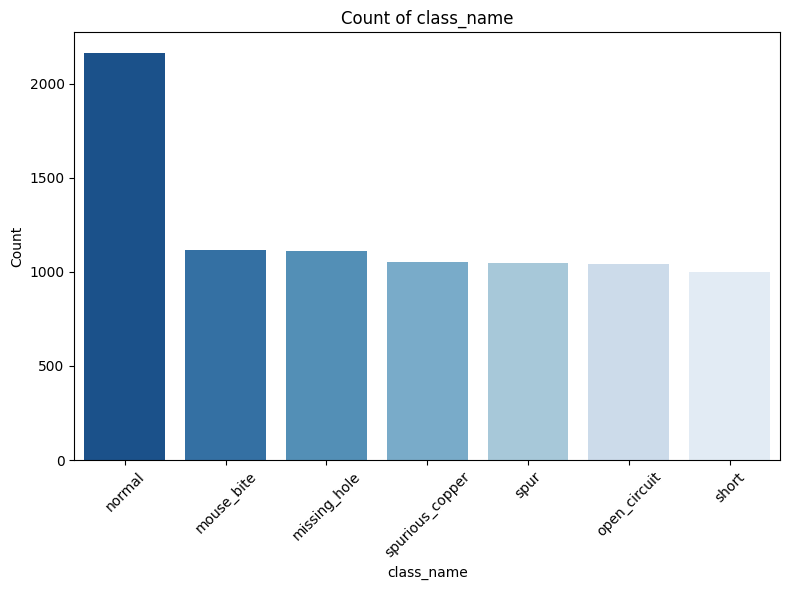

,class_name,count
0,normal,2164
1,mouse_bite,1118
2,missing_hole,1111
3,spurious_copper,1054
4,spur,1046
5,open_circuit,1042
6,short,999


In [6]:
count_plot(df=train_df, x_col='class_name', rotation=45)
train_df['class_name'].value_counts().reset_index()

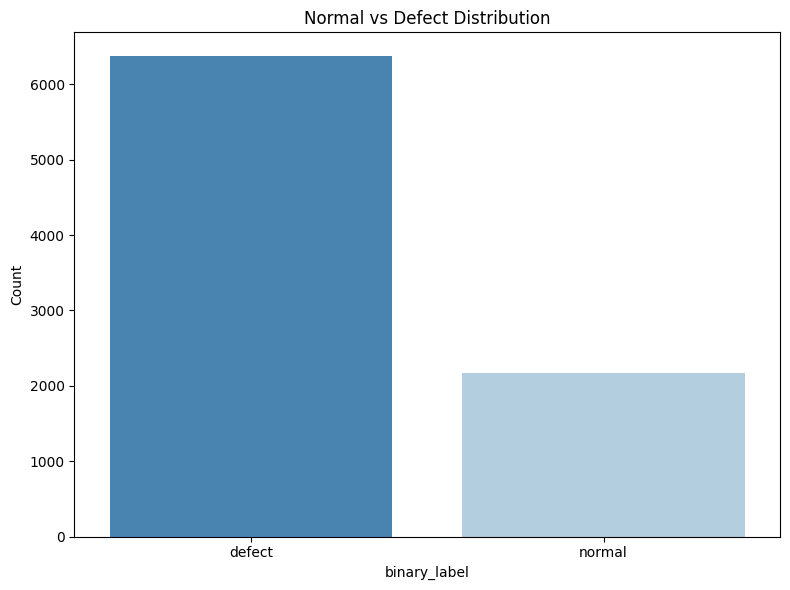

In [7]:
train_df['binary_label'] = train_df['class_name'].apply(
    lambda x: 'normal' if x == 'normal' else 'defect'
)

count_plot(
    train_df,
    x_col='binary_label',
    title='Normal vs Defect Distribution'
)

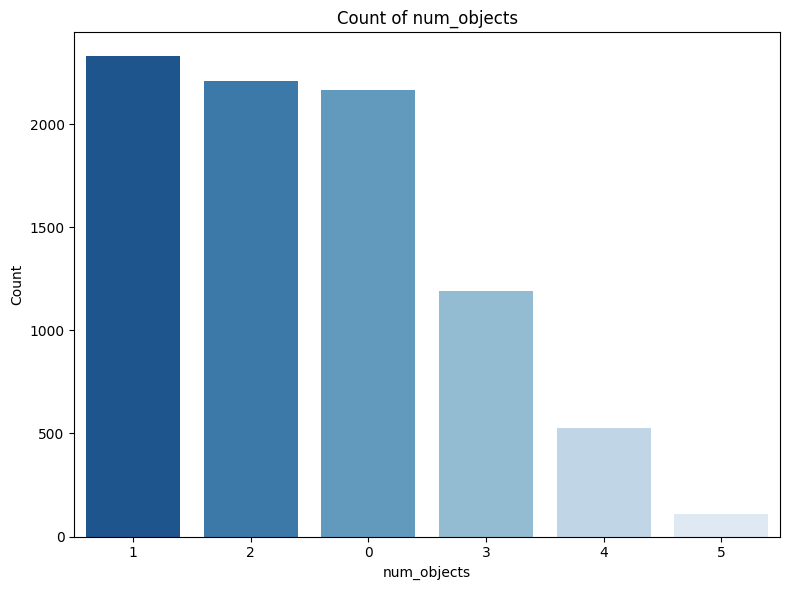

,num_objects,count,num_objects_ratio
0,1,2329,27.29
1,2,2210,25.90
2,0,2164,25.36
3,3,1193,13.98
4,4,527,6.18
5,5,111,1.30


In [19]:
count_plot(train_df, x_col='num_objects')
num_objects = train_df['num_objects'].value_counts().reset_index()
num_objects.columns = ['num_objects', 'count']

num_objects['num_objects_ratio'] = (
    num_objects['count'] / len(train_df) * 100
).round(2)
num_objects

### Val

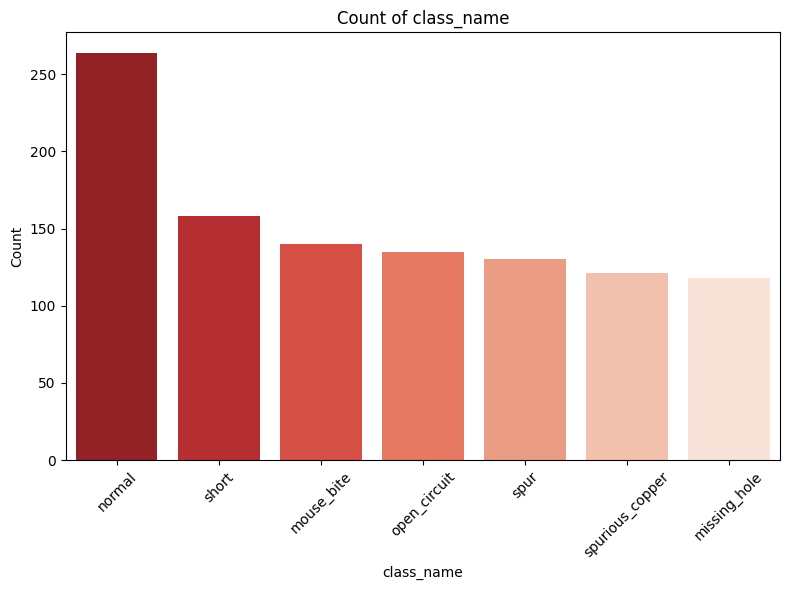

,class_name,count
0,normal,264
1,short,158
2,mouse_bite,140
3,open_circuit,135
4,spur,130
5,spurious_copper,121
6,missing_hole,118


In [24]:
count_plot(df=val_df, x_col='class_name', rotation=45, palette='Reds_r')
val_df['class_name'].value_counts().reset_index()

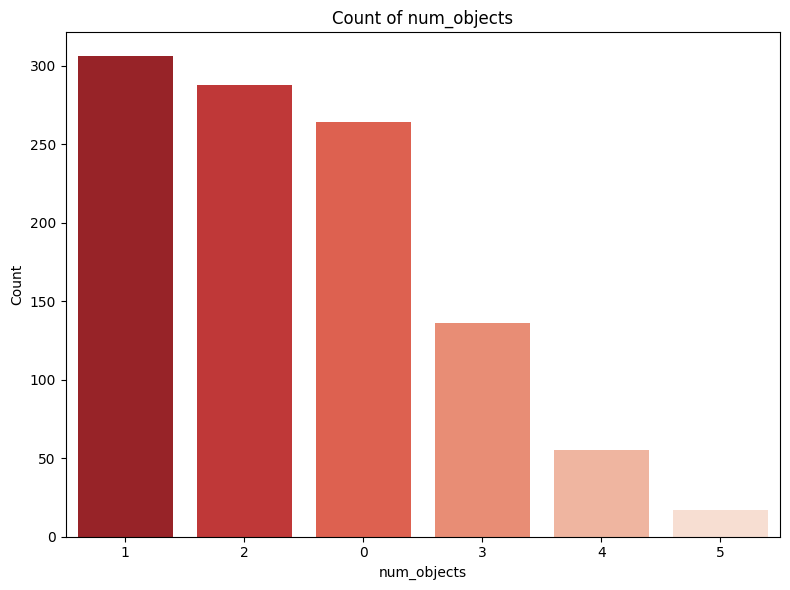

,num_objects,count,num_objects_ratio
0,1,306,28.71
1,2,288,27.02
2,0,264,24.77
3,3,136,12.76
4,4,55,5.16
5,5,17,1.59


In [25]:
count_plot(val_df, x_col='num_objects', palette='Reds_r')
num_objects = val_df['num_objects'].value_counts().reset_index()
num_objects.columns = ['num_objects', 'count']

num_objects['num_objects_ratio'] = (
    num_objects['count'] / len(val_df) * 100
).round(2)
num_objects

### Test

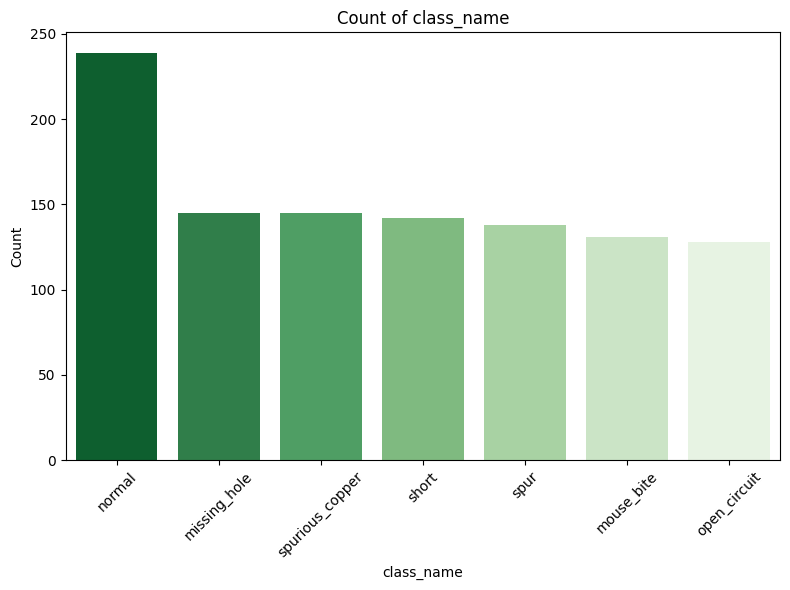

,class_name,count
0,normal,239
1,missing_hole,145
2,spurious_copper,145
3,short,142
4,spur,138
5,mouse_bite,131
6,open_circuit,128


In [26]:
count_plot(df=test_df, x_col='class_name', rotation=45, palette='Greens_r')
test_df['class_name'].value_counts().reset_index()

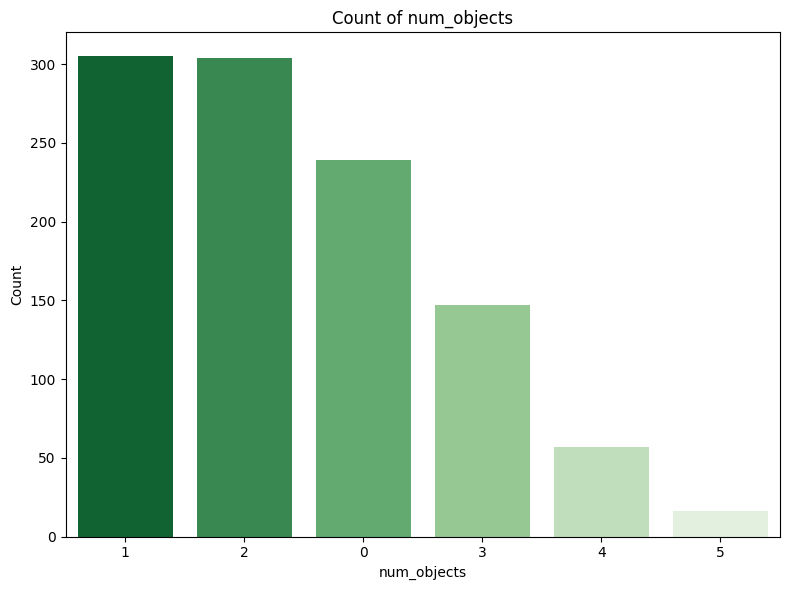

,num_objects,count,num_objects_ratio
0,1,305,28.56
1,2,304,28.46
2,0,239,22.38
3,3,147,13.76
4,4,57,5.34
5,5,16,1.50


In [27]:
count_plot(test_df, x_col='num_objects', palette='Greens_r')
num_objects = test_df['num_objects'].value_counts().reset_index()
num_objects.columns = ['num_objects', 'count']

num_objects['num_objects_ratio'] = (
    num_objects['count'] / len(test_df) * 100
).round(2)
num_objects

----

### BaseLine

In [ ]:
import sys
sys.path.append("../")

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
    
print(f"Added to sys.path: {PROJECT_ROOT}")

Added to sys.path: /Users/mungughyeon/Documents/Likelion/PCB


In [ ]:
from src.training.train import train_model
from src.models.model_factory import ModelFactory
from src.utils.config import load_config
from src.utils.logger import setup_logger

logger = setup_logger()

In [ ]:
config_path = '../configs/train_config.yaml'
config = load_config(config_path)

logger.info(f"Starting training for model: {config['model']['type']}{config['model']['size']}")
logger.info(f"Experiment results will be saved in: {config['training']['save_dir']}/{config['experiment']['name']}")

training_results = train_model(config_path=config_path)